In [1]:
import pandas as pd
import nltk
# Загружаем предобученную модель токенизации текста
nltk.download('punkt')
import csv
import os
import wget
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Загрузка датасета

In [2]:
news = pd.read_csv('./csv/news_lenta_ru.csv', engine='python', on_bad_lines='skip')

In [8]:
news.head()

,url,title,text,topic,tags
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая


Загрузка тонального словаря

In [9]:
url = 'https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv'
path = './csv/kartaslovsent.csv'
if not os.path.isfile("./csv/kartaslovsent.csv"):
    
    wget.download(url, out=path)

In [10]:
df_tone_dictionary = pd.read_csv('./csv/kartaslovsent.csv', sep=';', on_bad_lines='skip')

In [11]:
df_tone_dictionary.head()

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19


Присвоение метки настроения заголовкам

In [12]:
title_news_1, title_news_2 = train_test_split(news['title'], train_size=5, random_state=42)

In [13]:
df_title_news_1 = pd.DataFrame(title_news_1)
df_title_news_2 = pd.DataFrame(title_news_2)

In [14]:
df_title_news_1.head()

,title
5734,Ястржембский называет имя арестованного за взр...
5191,"Чемпионат Италии: ""Ювентус"" ушел в отрыв"
5390,Из Чернокозово отпущены первые амнистированные...
860,Парламент Украины затребовал у Конгресса США п...
7270,Пилот Формулы-1 уцелел в авиакатастрофе


In [15]:
df_title_news_2.head()

,title
6252,"Чтобы не платить налог, интернет-изданиям нужн..."
4684,Кубинского дипломата выставили из США
1731,Правительство РФ: третье тысячеление наступит ...
4742,Взрывчатку в Сибирь отправили по почте
4521,В Дагестане совершено покушение на генерала по...


Определение функций

In [32]:
def get_sentiment(text, df_td=df_tone_dictionary):
    '''
    Функция вычисляет метрику настроения.

    :param text: текст который будем анализировать,
    :param df_td: тональный словарь,
    :return: возвращает оценку тональности: -0.35 (неготив) <= нейтрально >= (0.55) позитив 
    '''
    
    words = nltk.word_tokenize(text.lower())
    sum_value = 0  
    
    for word in words:
        if len(df_td[df_td.term == word]):
            df_filtered = df_td[df_td['term'] == word]
            value = df_filtered['value'].iloc[0]
            sum_value += value
 
    return sum_value   

In [33]:
def get_sentiment_label(score):
    '''
    Функция выводит метку настроения (негативный, позитивный или нейтральный).

    :param score: уровень метки настроения от -1 до 1,
    :return: возвращает оценку тональности. 
    '''
    if score < -0.35:
        return 'negative'  
    elif score >= 0.55:
        return 'positive' 
    else:
        return 'neutral'


Проверка функций

In [39]:
%%time
get_sentiment('Превосходное утро!')

CPU times: total: 15.6 ms
Wall time: 24.5 ms


0.47

In [35]:
get_sentiment('Выстрел в спину')

-0.61

In [37]:
get_sentiment('Всё хорошо')

0

In [38]:
get_sentiment_label(get_sentiment('Превосходное утро'))

'neutral'

In [40]:
get_sentiment_label(get_sentiment('Выстрел в спину'))

'negative'

In [41]:
get_sentiment_label(get_sentiment('Всё хорошо'))

'neutral'

Присваеваем метки

In [42]:
%%time

df_title_news_2['sentiment'] = df_title_news_2['title'].apply(get_sentiment)

df_title_news_2['sentiment_label'] = df_title_news_2['sentiment'].apply(get_sentiment_label)

CPU times: total: 3min 54s
Wall time: 4min 3s


In [43]:
df_title_news_2.head()

,title,sentiment,sentiment_label
6252,"Чтобы не платить налог, интернет-изданиям нужн...",-0.26,neutral
4684,Кубинского дипломата выставили из США,0.00,neutral
1731,Правительство РФ: третье тысячеление наступит ...,-0.14,neutral
4742,Взрывчатку в Сибирь отправили по почте,0.00,neutral
4521,В Дагестане совершено покушение на генерала по...,-1.00,negative


In [44]:
df_title_news_2.shape

(9995, 3)

Присвоение меток настроения в label-studio

In [45]:
df_title_news_1.to_csv('./csv/manual_marking.csv', index=False)

In [46]:
!label-studio

"label-studio" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Экспортируем размеченный вручную CSV файл и зогружаем его в датафрейм

In [47]:
df_title_news_1 = pd.read_csv('./csv/project-1-at-2024-04-14-20-19-3822a918.csv', engine='python', on_bad_lines='skip')

In [48]:
df_title_news_1.head()

,annotation_id,annotator,created_at,id,lead_time,sentiment,title,updated_at
0,1,1,2024-04-14T16:08:25.109948Z,1,18.735,positive,Ястржембский называет имя арестованного за взр...,2024-04-14T16:08:33.034497Z
1,2,1,2024-04-14T16:09:05.374325Z,2,13.131,neutral,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",2024-04-14T16:17:06.400265Z
2,3,1,2024-04-14T16:09:26.498394Z,3,6.770,negative,Из Чернокозово отпущены первые амнистированные...,2024-04-14T16:09:26.498394Z
3,4,1,2024-04-14T16:09:59.909605Z,4,7.341,neutral,Парламент Украины затребовал у Конгресса США п...,2024-04-14T16:09:59.909605Z
4,5,1,2024-04-14T16:10:25.863949Z,5,4.486,positive,Пилот Формулы-1 уцелел в авиакатастрофе,2024-04-14T16:10:25.863949Z


In [49]:
df_title_news_1 = df_title_news_1[['title', 'sentiment']].rename(columns={'sentiment': 'sentiment_label'})

In [50]:
df_title_news_1.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


Объединение датафреймов

In [51]:
df_title_news_concat = pd.concat([
    df_title_news_1,
    df_title_news_2,
], axis=0)

del df_title_news_concat['sentiment']

In [52]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


In [53]:
df_title_news_concat.shape

(10000, 2)

<AxesSubplot: >

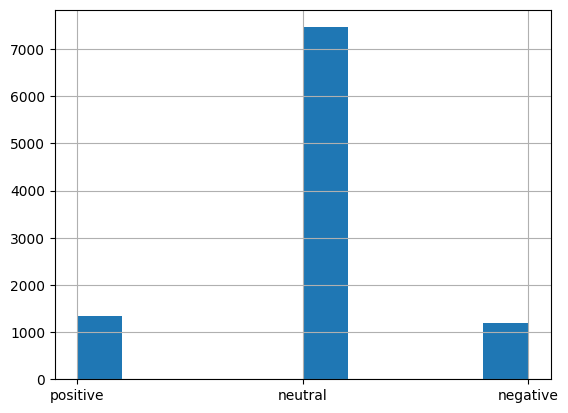

In [55]:
df_title_news_concat['sentiment_label'].hist()

Статистика тональности заголоаков новостей

In [56]:
df_title_news_concat.groupby(['sentiment_label']).agg({'sentiment_label': ['count']})

,sentiment_label
,count
sentiment_label,
negative,1186
neutral,7463
positive,1351


Обучение модели

In [57]:
le = LabelEncoder()
# Преобразуем в датафрейме буквеное обозначение в цифровое
df_title_news_concat['sentiment_label'] = le.fit_transform(df_title_news_concat['sentiment_label'].astype(str))

In [58]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,2
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",1
2,Из Чернокозово отпущены первые амнистированные...,0
3,Парламент Украины затребовал у Конгресса США п...,1
4,Пилот Формулы-1 уцелел в авиакатастрофе,2


In [59]:
df_title_news_concat = shuffle(df_title_news_concat)

In [60]:
# Разделение датасета на размеченную и неразмеченную выборки
labeled_title, unlabeled_title = train_test_split(df_title_news_concat, train_size=0.2, random_state=42)

In [61]:
labeled_title.head()

,title,sentiment_label
130,Москвичи не хотят видеть Лужкова президентом,2
4357,В Москве неизвестные напали на пост милиции,1
733,Mitsubishi ставит мировой рекорд по экономичности,2
2004,Старейший питерский провайдер куплен западным ...,2
3773,Правительство Москвы будет бороться с приезжим...,1


In [62]:
unlabeled_title.head()

,title,sentiment_label
1851,"Таможня задержала 2000 ""Знаменитых чеченцев""",1
8256,В Бельгии освобождены 550 заложников,1
3914,Буратаеву восстановили в депутатах,1
945,"Нобелевскую премию мира дали ""Врачам без границ""",2
2641,"Налоговики заблокировали счета ""Росэнергоатома""",1


Определение функции для обучения модели логистической регрессии на размеченных данных

In [63]:
def train_model(labeled_title):
    # Векторизация текстовых данных с помощью TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_title['title'])
    y = labeled_title['sentiment_label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

Обучение начальной модели на небольшом наборе 

In [64]:
model, vectorizer = train_model(labeled_title)

In [65]:
X_unlabeled = vectorizer.transform(unlabeled_title['title'])
y_unlabeled_predicted = model.predict(X_unlabeled)

In [66]:
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

Выбор 100 наиболее неопределенных точек данных для маркировки человеком

In [67]:
labeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[:100]]
unlabeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[100:]]

In [68]:
labeled_title_new

,title,sentiment_label
1356,"Москва выделяет ""Метрострою"" 35 миллионов рублей",1
7631,Количество боевиков в Чечне увеличивается?,1
7021,В нынешнем году в Чечне задержаны 1428 пособни...,1
3006,Министерство госбезопасности Грузии: баз чечен...,1
1978,Проигравший кандидат в президенты Украины пода...,1
...,...,...
6028,Путин не услышит доводов Робинсон,1
3267,Путин распределил обязанности между замами,1
9940,Путин распорядился сократить разрыв между пенс...,1
7586,В Чечне ликвидирована крупная база боевиков,1


Разметка новых точек данных и добавление их к размеченному множеству

In [69]:
labeled_title = pd.concat([labeled_title, labeled_title_new])

In [70]:
labeled_title.shape

(2100, 2)

In [71]:
unlabeled_title_new.shape

(7900, 2)

Переобучение модели на расширенном маркированном множестве

In [72]:
model, vectorizer = train_model(labeled_title)

Оценка обучения модели

Загружаем тестовый датасет

In [73]:
title_test = pd.read_csv('./csv/test.csv', engine='python', on_bad_lines='skip')

In [74]:
title_test['sentiment_label'] = le.fit_transform(title_test['sentiment_label'].astype(str))

In [75]:
title_test.head()

,title,sentiment_label
0,Вагоны московского метро будут складываться га...,1
1,В Чечню пытались проникнуть наемники из Пакистана,1
2,Таллинские заключенные предпочитают голод духоте,0
3,"Адвокатам ""Моста"" не удалось дать отвод следов...",1
4,В поезде Донецк-Москва нашли взрывчатку,1


Оценка модели на тестовом датасете

In [76]:
X_test = vectorizer.transform(title_test['title'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(title_test['sentiment_label'], y_test_predicted, average='micro')

print(f1)

0.84208
